# Fine-Tuning a Semantic Segmentation Model on a Custom Dataset and Usage via the Inference API


_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

In this notebook, we will walk through the process of fine-tuning a [semantic segmentation](https://huggingface.co/tasks/image-segmentation) model on a custom dataset. The model we'll be using is the pretrained [Segformer](https://huggingface.co/docs/transformers/model_doc/segformer), a powerful and flexible transformer-based architecture for segmentation tasks.

![Segformer architecture](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/segformer_architecture.png)


For our dataset, we'll use [segments/sidewalk-semantic](https://huggingface.co/datasets/segments/sidewalk-semantic), which contains labeled images of sidewalks, making it ideal for applications in urban environments.

Example use-case: This model could be deployed in a delivery robot that autonomously navigates sidewalks to deliver pizza right to your door 🍕

Once we've fine-tuned the model, we'll demonstrate how to deploy it using the [Serverless Inference API](https://huggingface.co/docs/api-inference/index), making it accessible via a simple API endpoint.

## 1. Install Dependencies

To begin, we’ll install the essential libraries required for fine-tuning our semantic segmentation model.




In [ ]:
!pip install -q datasets transformers evaluate wandb
# Tested with datasets==3.0.0, transformers==4.44.2, evaluate==0.4.3, wandb==0.18.1

## 2. Loading the Dataset 📁

We'll be using the [sidewalk-semantic](https://huggingface.co/datasets/segments/sidewalk-semantic) dataset, which consists of images of sidewalks collected in Belgium during the summer of 2021.

The dataset includes:

* **1,000 images along with their corresponding semantic segmentation masks** 🖼
* **34 distinct categories** 📦

Since this dataset is gated, you'll need to log in and accept the license to gain access. We also require authentication to upload the fine-tuned model to the Hub after training.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
sidewalk_dataset_identifier = "segments/sidewalk-semantic"

In [ ]:
from datasets import load_dataset

dataset = load_dataset(sidewalk_dataset_identifier)

Review the internal structure to get familiar with it!



In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

Since the dataset only includes a training split, we will manually divide it into `training and test sets`. We'll allocate 80% of the data for training and reserve the remaining 20% for evaluation and testing. ➗


In [6]:
dataset = dataset.shuffle(seed=42)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

Let's examine the types of objects present in an example. We can see that `pixels_values` holds the RGB image, while `label` contains the ground truth mask. The mask is a single-channel image where each pixel represents the category of the corresponding pixel in the RGB image.


In [7]:
image = train_ds[0]
image

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>}

## 3. Visualizing Examples! 👀

Now that we’ve loaded the dataset, let’s visualize a few examples along with their masks to understand its structure better.

The dataset includes a JSON [file](https://huggingface.co/datasets/segments/sidewalk-semantic/blob/main/id2label.json) containing the `id2label` mapping. We’ll open this file to read the category labels associated with each ID.






In [8]:
import json
from huggingface_hub import hf_hub_download

filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=sidewalk_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

id2label.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

Id2label: {0: 'unlabeled', 1: 'flat-road', 2: 'flat-sidewalk', 3: 'flat-crosswalk', 4: 'flat-cyclinglane', 5: 'flat-parkingdriveway', 6: 'flat-railtrack', 7: 'flat-curb', 8: 'human-person', 9: 'human-rider', 10: 'vehicle-car', 11: 'vehicle-truck', 12: 'vehicle-bus', 13: 'vehicle-tramtrain', 14: 'vehicle-motorcycle', 15: 'vehicle-bicycle', 16: 'vehicle-caravan', 17: 'vehicle-cartrailer', 18: 'construction-building', 19: 'construction-door', 20: 'construction-wall', 21: 'construction-fenceguardrail', 22: 'construction-bridge', 23: 'construction-tunnel', 24: 'construction-stairs', 25: 'object-pole', 26: 'object-trafficsign', 27: 'object-trafficlight', 28: 'nature-vegetation', 29: 'nature-terrain', 30: 'sky', 31: 'void-ground', 32: 'void-dynamic', 33: 'void-static', 34: 'void-unclear'}


Let's assign colors to each category 🎨. This will help us visualize the segmentation results more effectively and make it easier to interpret the different categories in our images.


In [9]:
sidewalk_palette = [
  [0, 0, 0], # unlabeled
  [216, 82, 24], # flat-road
  [255, 255, 0], # flat-sidewalk
  [125, 46, 141], # flat-crosswalk
  [118, 171, 47], # flat-cyclinglane
  [161, 19, 46], # flat-parkingdriveway
  [255, 0, 0], # flat-railtrack
  [0, 128, 128], # flat-curb
  [190, 190, 0], # human-person
  [0, 255, 0], # human-rider
  [0, 0, 255], # vehicle-car
  [170, 0, 255], # vehicle-truck
  [84, 84, 0], # vehicle-bus
  [84, 170, 0], # vehicle-tramtrain
  [84, 255, 0], # vehicle-motorcycle
  [170, 84, 0], # vehicle-bicycle
  [170, 170, 0], # vehicle-caravan
  [170, 255, 0], # vehicle-cartrailer
  [255, 84, 0], # construction-building
  [255, 170, 0], # construction-door
  [255, 255, 0], # construction-wall
  [33, 138, 200], # construction-fenceguardrail
  [0, 170, 127], # construction-bridge
  [0, 255, 127], # construction-tunnel
  [84, 0, 127], # construction-stairs
  [84, 84, 127], # object-pole
  [84, 170, 127], # object-trafficsign
  [84, 255, 127], # object-trafficlight
  [170, 0, 127], # nature-vegetation
  [170, 84, 127], # nature-terrain
  [170, 170, 127], # sky
  [170, 255, 127], # void-ground
  [255, 0, 127], # void-dynamic
  [255, 84, 127], # void-static
  [255, 170, 127], # void-unclear
]

We can visualize some examples from the dataset, including the RGB image, the corresponding mask, and an overlay of the mask on the image. This will help us better understand the dataset and how the masks correspond to the images. 📸


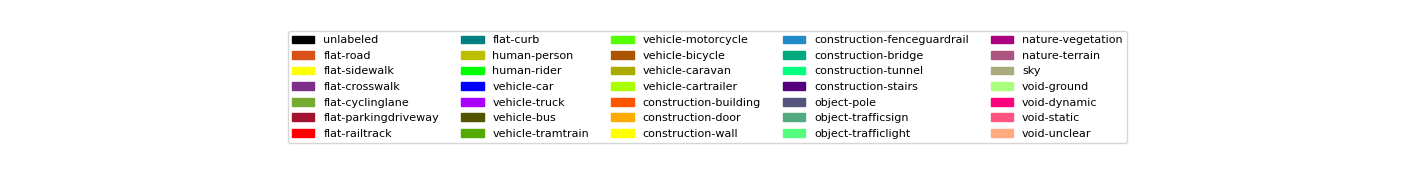

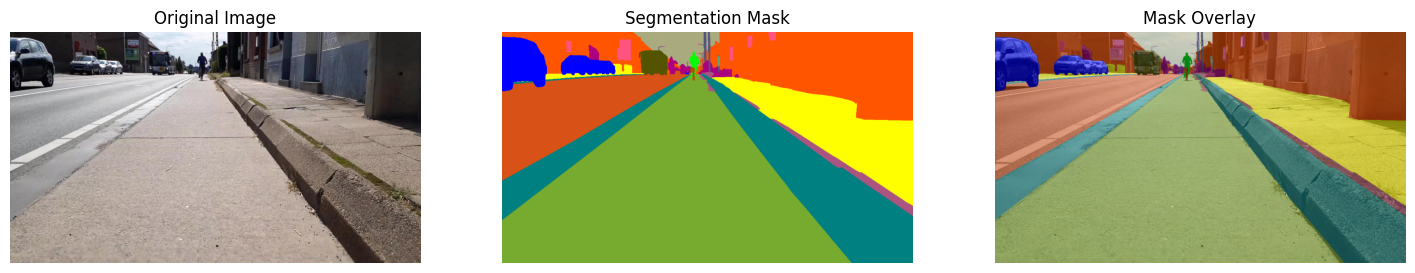

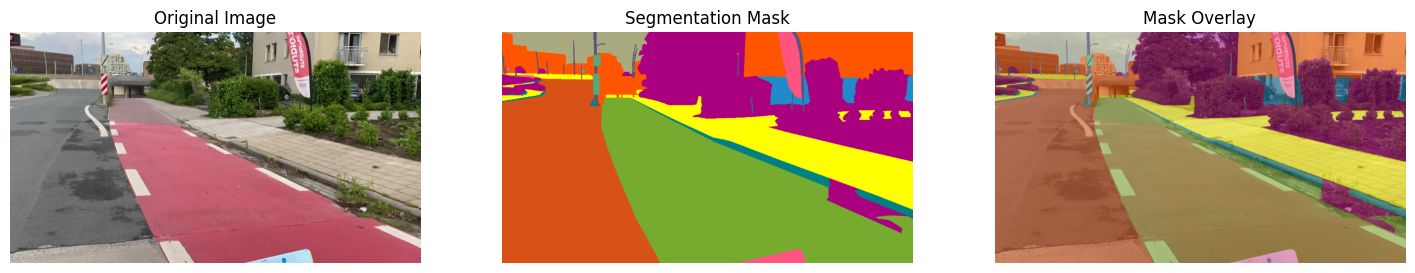

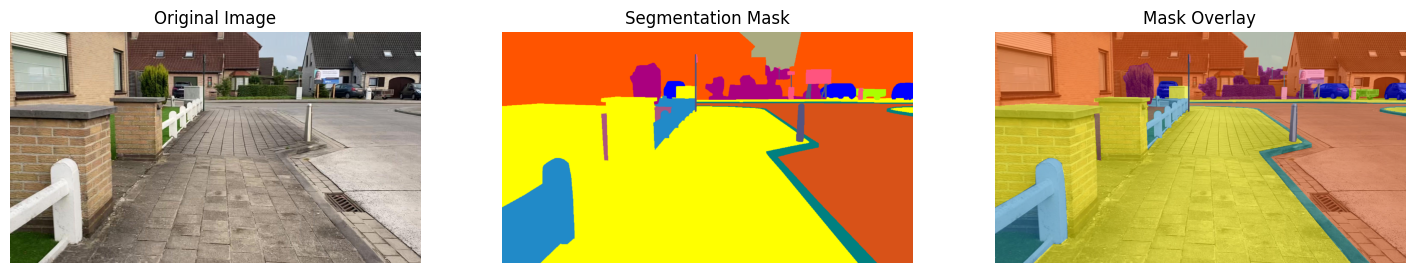

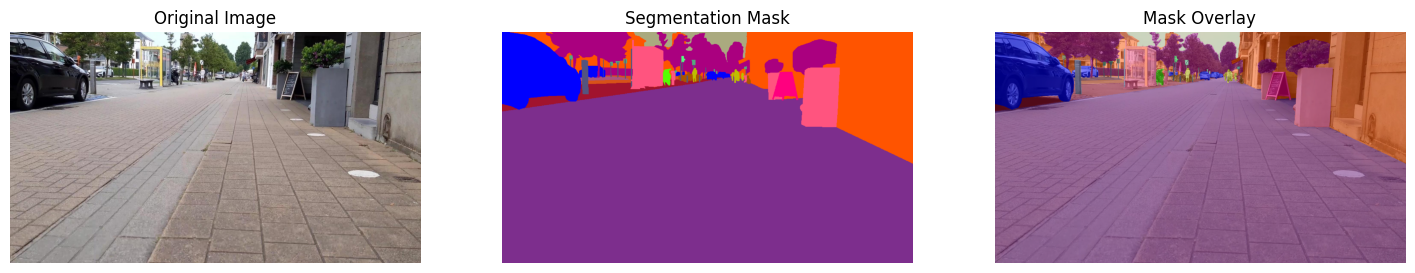

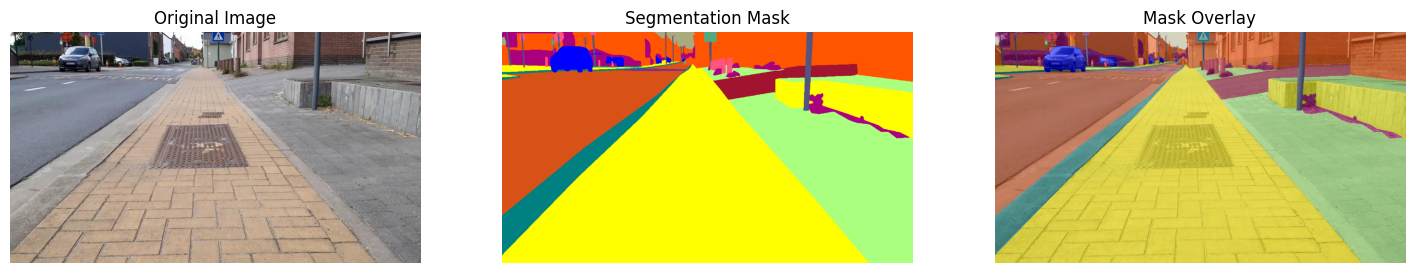

In [10]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

# Create and show the legend separately
fig, ax = plt.subplots(figsize=(18, 2))

legend_patches = [patches.Patch(color=np.array(color)/255, label=label) for label, color in zip(id2label.values(), sidewalk_palette)]

ax.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 0.5), ncol=5, fontsize=8)
ax.axis('off')

plt.show()

for i in range(5):
    image = train_ds[i]

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Show the original image
    ax[0].imshow(image['pixel_values'])
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    mask_np = np.array(image['label'])

    # Create a new empty RGB image
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Assign colors to each value in the mask
    for label_id, color in enumerate(sidewalk_palette):
        colored_mask[mask_np == label_id] = color

    colored_mask_img = Image.fromarray(colored_mask, 'RGB')

    # Show the segmentation mask
    ax[1].imshow(colored_mask_img)
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    # Convert the original image to RGBA to support transparency
    image_rgba = image['pixel_values'].convert("RGBA")
    colored_mask_rgba = colored_mask_img.convert("RGBA")

    # Adjust transparency of the mask
    alpha = 128  # Transparency level (0 fully transparent, 255 fully opaque)
    image_2_with_alpha = Image.new("RGBA", colored_mask_rgba.size)
    for x in range(colored_mask_rgba.width):
        for y in range(colored_mask_rgba.height):
            r, g, b, a = colored_mask_rgba.getpixel((x, y))
            image_2_with_alpha.putpixel((x, y), (r, g, b, alpha))

    superposed = Image.alpha_composite(image_rgba, image_2_with_alpha)

    # Show the mask overlay
    ax[2].imshow(superposed)
    ax[2].set_title('Mask Overlay')
    ax[2].axis('off')

    plt.show()

## 4. Visualize Class Occurrences 📊

To gain deeper insights into the dataset, let’s plot the occurrences of each class. This will allow us to understand the distribution of classes and identify any potential biases or imbalances in the dataset.


In [11]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.zeros(len(id2label))

for example in train_ds:
    mask_np = np.array(example['label'])
    unique, counts = np.unique(mask_np, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] += c

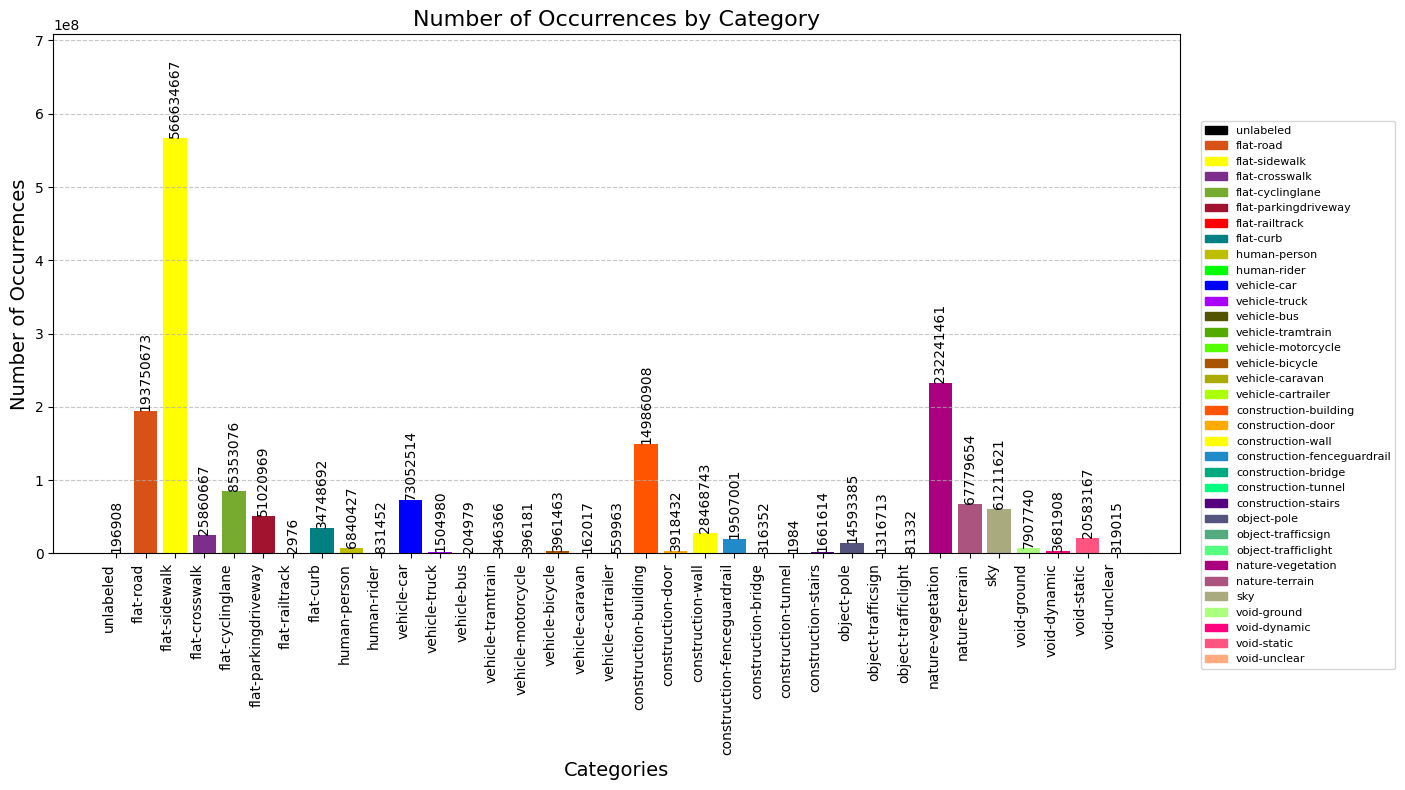

In [12]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import patches

labels = list(id2label.values())

# Normalize colors to be in the range [0, 1]
normalized_palette = [tuple(c / 255 for c in color) for color in sidewalk_palette]

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(range(len(labels)), class_counts, color=[normalized_palette[i] for i in range(len(labels))])

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha="right")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Number of Occurrences by Category", fontsize=16)

ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust the y-axis limit
y_max = max(class_counts)
ax.set_ylim(0, y_max * 1.25)

for bar in bars:
    height = int(bar.get_height())
    offset = 10  # Adjust the text location
    ax.text(bar.get_x() + bar.get_width() / 2.0, height + offset, f"{height}",
            ha="center", va="bottom", rotation=90, fontsize=10, color='black')

fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=8)  # Adjust ncol as needed

plt.tight_layout()
plt.show()


## 5. Initialize Image Processor and Add Data Augmentation with Albumentations 📸

We will start by initializing the image processor and then apply data augmentation 🪄 using [Albumentations](https://albumentations.ai/). This will help enhance our dataset and improve the performance of our semantic segmentation model.


In [31]:
import albumentations as A
from transformers import SegformerImageProcessor

image_processor = SegformerImageProcessor()

albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7),
    A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, val_shift_limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GaussNoise(var_limit=(10, 50), p=0.4),
])

def train_transforms(example_batch):
    augmented = [
        albumentations_transform(image=np.array(image), mask=np.array(label))
        for image, label in zip(example_batch['pixel_values'], example_batch['label'])
    ]
    augmented_images = [item['image'] for item in augmented]
    augmented_labels = [item['mask'] for item in augmented]
    inputs = image_processor(augmented_images, augmented_labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = image_processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

## 6. Initialize Model from Checkpoint

We will use a pretrained Segformer model from the checkpoint: [nvidia/mit-b0](https://huggingface.co/nvidia/mit-b0). This architecture is detailed in the paper [SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers](https://arxiv.org/abs/2105.15203) and has been trained on ImageNet-1k.


In [ ]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

## 7. Set Training Arguments and Connect to Weights & Biases 📉

Next, we'll configure the training arguments and connect to [Weights & Biases (W&B)](https://wandb.ai/). W&B will assist us in tracking experiments, visualizing metrics, and managing the model training workflow, providing valuable insights throughout the process.


In [ ]:
from transformers import TrainingArguments

output_dir = "test-segformer-b0-segments-sidewalk-finetuned"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=6e-5,
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to="wandb"
)

In [ ]:
import wandb

wandb.init(
    project="test-segformer-b0-segments-sidewalk-finetuned",  # change this
    name="test-segformer-b0-segments-sidewalk-finetuned",  # change this
    config=training_args,
)

## 8. Set Custom `compute_metrics` Method for Enhanced Logging with `evaluate`

We will use the [mean Intersection over Union (mean IoU)](https://huggingface.co/spaces/evaluate-metric/mean_iou) as the primary metric to evaluate the model’s performance. This will allow us to track performance across each category in detail.

Additionally, we’ll adjust the logging level of the evaluation module to minimize warnings in the output. If a category is not detected in an image, you might see warnings like the following:

```
RuntimeWarning: invalid value encountered in divide iou = total_area_intersect / total_area_union
```


You can skip this cell if you prefer to see these warnings and proceed to the next step.


In [35]:
import evaluate
evaluate.logging.set_verbosity_error()

In [36]:
import torch
from torch import nn
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    # currently using _compute instead of compute: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    pred_labels = logits_tensor.detach().cpu().numpy()
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=image_processor.do_reduce_labels,
            )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

## 9. Train the Model on Our Dataset 🏋

Now it's time to train the model on our custom dataset. We’ll use the prepared training arguments and the connected Weights & Biases integration to monitor the training process and make adjustments as needed. Let’s start the training and watch the model improve its performance!


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [38]:
trainer.train()

TrainOutput(global_step=2000, training_loss=0.8801042995750904, metrics={'train_runtime': 5698.7353, 'train_samples_per_second': 2.808, 'train_steps_per_second': 0.351, 'total_flos': 2.81087582404608e+17, 'train_loss': 0.8801042995750904, 'epoch': 20.0})

## 10. Evaluate Model Performance on New Images 📸

After training, we’ll assess the model’s performance on new images. We’ll use a test image and leverage a [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines) to evaluate how well the model performs on unseen data.


In [ ]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

image = Image.open(requests.get(url, stream=True).raw)

image_segmentator = pipeline(
    "image-segmentation", model="sergiopaniego/test-segformer-b0-segments-sidewalk-finetuned" # Change with your model name
)

results = image_segmentator(image)

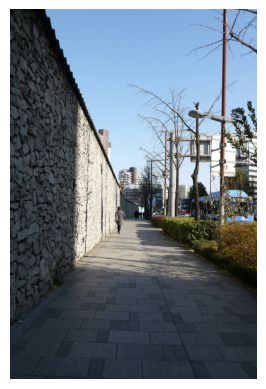

In [40]:
plt.imshow(image)
plt.axis('off')
plt.show()

The model has generated some masks, so we can visualize them to evaluate and understand its performance. This will help us see how well the model is segmenting the images and identify any areas for improvement.


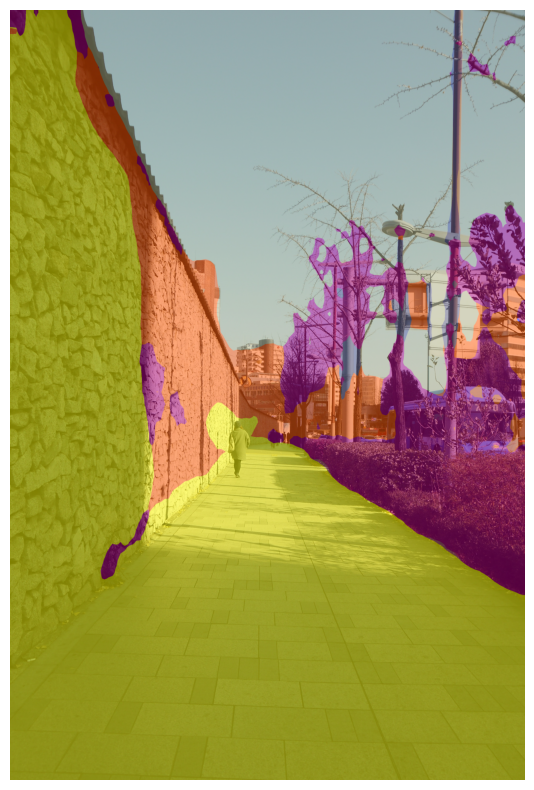

In [41]:
image_array = np.array(image)

segmentation_map = np.zeros_like(image_array)

for result in results:
    mask = np.array(result['mask'])
    label = result['label']

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis('off')
plt.show()

## 11. Evaluate Performance on the Test Set 📊


In [42]:
metrics = trainer.evaluate(test_ds)
print(metrics)

{'eval_loss': 0.6063494086265564, 'eval_mean_iou': 0.26682655949637757, 'eval_mean_accuracy': 0.3233445959272099, 'eval_overall_accuracy': 0.834762670692357, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_flat-road': 0.8794976463015708, 'eval_accuracy_flat-sidewalk': 0.9287807675111692, 'eval_accuracy_flat-crosswalk': 0.5247038032656313, 'eval_accuracy_flat-cyclinglane': 0.795399495199148, 'eval_accuracy_flat-parkingdriveway': 0.4010852199852775, 'eval_accuracy_flat-railtrack': nan, 'eval_accuracy_flat-curb': 0.4902816930389514, 'eval_accuracy_human-person': 0.5913439011934908, 'eval_accuracy_human-rider': 0.0, 'eval_accuracy_vehicle-car': 0.9253204043875328, 'eval_accuracy_vehicle-truck': 0.0, 'eval_accuracy_vehicle-bus': 0.0, 'eval_accuracy_vehicle-tramtrain': 0.0, 'eval_accuracy_vehicle-motorcycle': 0.0, 'eval_accuracy_vehicle-bicycle': 0.0013499147866290941, 'eval_accuracy_vehicle-caravan': 0.0, 'eval_accuracy_vehicle-cartrailer': 0.0, 'eval_accuracy_construction-building': 0.88155

## 12. Access the Model Using the Inference API and Visualize Results 🔌


Hugging Face 🤗 provides a [Serverless Inference API](https://huggingface.co/docs/api-inference/index) that allows you to test models directly via API endpoints for free. For detailed guidance on using this API, check out this [cookbook](https://huggingface.co/learn/cookbook/enterprise_hub_serverless_inference_api).

We will use this API to explore its functionality and see how it can be leveraged for testing our model.

**IMPORTANT**

Before using the Serverless Inference API, you need to set the model task by creating a model card. When creating the model card for your fine-tuned model, ensure that you specify the task appropriately.

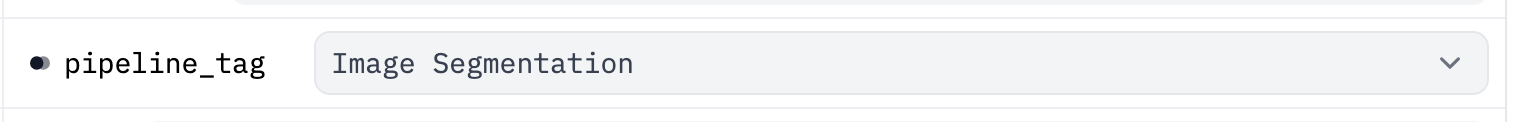


Once the model task is set up, we can download an image and use the [InferenceClient](https://huggingface.co/docs/huggingface_hub/v0.25.0/en/package_reference/inference_client) to test the model. This client will allow us to send the image to the model through the API and retrieve the results for evaluation.


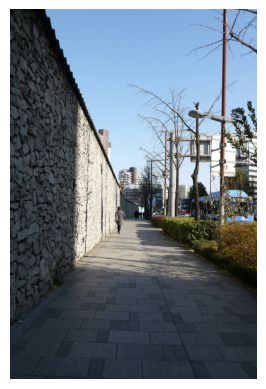

In [47]:
url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)
plt.axis('off')
plt.show()

We will use the [image_segmentation](https://huggingface.co/docs/huggingface_hub/v0.25.0/en/package_reference/inference_client#huggingface_hub.InferenceClient.image_segmentation) method from the InferenceClient. This method takes the model and an image as inputs and returns the predicted masks. This will allow us to test how well the model performs on new images.


In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient()

response = client.image_segmentation(
    model="sergiopaniego/test-segformer-b0-segments-sidewalk-finetuned", # Change with your model name
    image='https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'
)

print(response)

With the predicted masks, we can display the results.

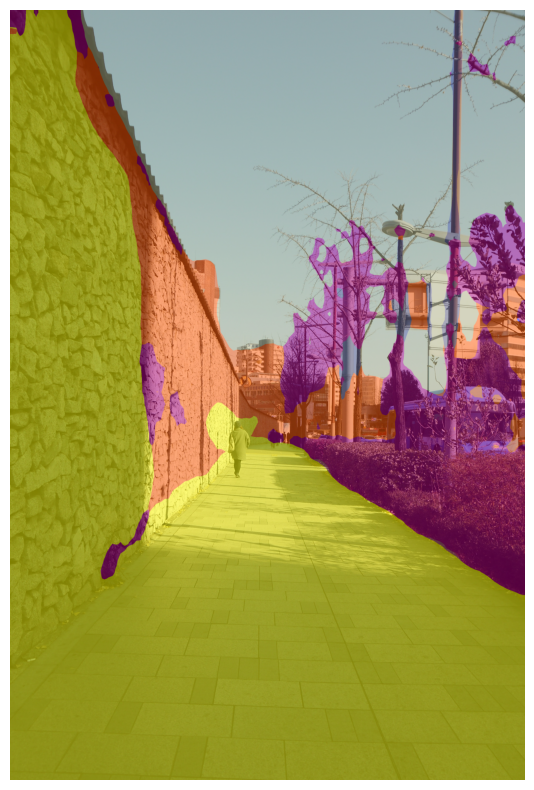

In [55]:
image_array = np.array(image)
segmentation_map = np.zeros_like(image_array)

for result in response:
    mask = np.array(result['mask'])
    label = result['label']

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis('off')
plt.show()

It’s also possible to use the [Inference API with JavaScript](https://huggingface.co/tasks/image-segmentation). Here’s an example of how you can consume the API using JavaScript:

```
import { HfInference } from "@huggingface/inference";

const inference = new HfInference(HF_TOKEN);
await inference.imageSegmentation({
    data: await (await fetch("https://picsum.photos/300/300")).blob(),
    model: "sergiopaniego/segformer-b0-segments-sidewalk-finetuned",
});

```



**Extra Points**

You can also deploy the fine-tuned model using a Hugging Face Space. For example, I have created a custom Space to showcase this: [Semantic Segmentation with SegFormer Fine-Tuned on Segments/Sidewalk](https://huggingface.co/spaces/sergiopaniego/segformer-b0-segments-sidewalk-finetuned).

<img src="https://huggingface.co/front/thumbnails/spaces.png" alt="HF Spaces logo" width="20%">


In [ ]:
from IPython.display import IFrame
IFrame(src='https://sergiopaniego-segformer-b0-segments-sidewalk-finetuned.hf.space', width=1000, height=800)

## Conclusion

In this guide, we successfully fine-tuned a semantic segmentation model on a custom dataset and utilized the Serverless Inference API to test it. This demonstrates how easily you can integrate the model into various applications and leverage Hugging Face tools for deployment.

I hope this guide provides you with the tools and knowledge to confidently fine-tune and deploy your own models! 🚀